In [1]:
import eumdac
import datetime
import shutil
from datetime import timedelta
from sentinelsat import read_geojson, geojson_to_wkt
import zipfile
import gzip
import os
import pandas as pd
from glob import glob

download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

/mnt/beegfs/home/alexisa2019/.conda/envs/myCdom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ls

GOMEX_FB.geojson     Sentinel Vis.ipynb
LakeO.geojson        Sentinel3_2022-07-23T15:03:26_-82_26_rgb.png
Outdated Notebooks/  Sentinel3_2022-07-23T15:03:26_rgb.png
README.md            SentinelExp.py
S3Download.ipynb     flbay.geojson
S3rgb.png            gomex.geojson
Sentinel DL.ipynb    products/


<function dir>

In [2]:
from satpy import Scene, find_files_and_readers
from satpy.writers import get_enhanced_image
from pyresample import create_area_def
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [3]:
def get_datastore(consumer_key, consumer_secret):
    token = eumdac.AccessToken((consumer_key, consumer_secret))
    print(f"This token '{token}' expires {token.expiration}")
    return eumdac.DataStore(token)

# How to figure out a good pixel extent

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def Sentinel_request(datastore, roi, lon1, lon2, lat1, lat2,
                     collectionID='EO:EUM:DAT:0409',
#                      geojson_file, 
                     opath = './',
                     start_date = None, end_date = None, suffix = None):
    
    if(suffix == None):
        suffix = f"{str(lon1)}_{str(lat1)}"

    WKT = 'POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi]))
    selected_collection = datastore.get_collection(collectionID)
    print(selected_collection.title)
    
    if(end_date == None):
        end_date = datetime.date.today()
    if(start_date == None):
        start_date = end_date-timedelta(days=1)
        
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    print('Searching from %s to %s' %(start_date, end_date))
    products = selected_collection.search(geo=WKT, 
                                          dtstart=start_date, 
                                          dtend=end_date)
    print(f'Found Datasets: {len(products)} datasets for the given time range')
    for product in products:
        with product.open() as fsrc, open(opath+fsrc.name, mode='wb') as fdst:
#             if os.path.isfile(fdst.name):
            if os.path.getsize(fdst.name)>0:

                print(f'Product {fdst.name} exists.')
            else:
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of product {product} finished.')
    print('All downloads are finished.')
            
    rpath = opath+'S3_%s_%s' % (start_date.strftime("%Y%m%d"),
                                start_date.strftime("%Y%m%d"))                    
    for f in glob(opath+'S3*.zip'):
        try:
            with zipfile.ZipFile(f, 'r') as zip_ref:
                print('Unziping %s' %f)
                zip_ref.extractall(rpath)
                os.remove(f)
        except:
            print('Bad zip file: %s' %f)

    print(f'Done! Files in {rpath}')
    
    # VISUALIZING...
    
    print("Starting visualization :D")
    
    files = find_files_and_readers(sensor='olci',
                               start_time=start_date,
                               end_time=end_date,
                               base_dir='./products/S3_20220723_20220723',
                               reader='olci_l1b')

    scn = Scene(filenames=files)
    scn.load(['true_color'])

    meanWidth = .5*(haversine(lon1, lat1, lon2, lat1)+haversine(lon1, lat2, lon2, lat2))

    height = haversine(lon1, lat1, lon1, lat2)

    pixWidth = (int(meanWidth) * 1000) / 300
    pixHeight = (int(height) * 1000) / 300

    print(f"Width: {meanWidth}, Height: {height}")
    print(f"%Width: {pixWidth}, %Height: {pixHeight}")

    my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                          width=pixWidth, height=pixHeight,
                          area_extent=[lon1, lat1, lon2, lat2], units='degrees')
    new_scn = scn.resample(my_area)
    #generate RGB from true color
    rgb = get_enhanced_image(new_scn['true_color'])
    #extract projection and lon lat from products
    crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()

    fig =  plt.figure(figsize=(6, 4), dpi=400)
    ax1 = plt.subplot(projection=crs)
    rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax1)
    ax1.set_title('Sentinel3_%s_%s' % (new_scn.start_time.isoformat(), suffix))
    
    #save figure
    fig.savefig('Sentinel3_%s_%s_rgb.png' % (new_scn.start_time.isoformat(), suffix))

In [5]:
consumer_key = 'yawsJIqGoAetBf_MqpcByUwnrWMa'
consumer_secret = 'w6nWuFAtEgPhFESfK7Q4MzOs9t0a'

roi = [[-81.0955810546875,26.675685969067487],
       [-80.54489135742188,26.675685969067487],
       [-80.54489135742188,27.243641579169292],
       [-81.0955810546875,27.243641579169292],
       [-81.0955810546875,26.675685969067487]]

datastore = get_datastore(consumer_key, consumer_secret)
Sentinel_request(datastore, roi, opath='./products/', start_date=datetime.date(2022,7,23),
                 end_date=datetime.date(2022,7,24))

This token '5e55fa44-43c6-3294-b03d-535ddca1540b' expires 2022-08-25 10:40:02.513804
OLCI Level 1B Full Resolution - Sentinel-3
Searching from 2022-07-23 00:00:00 to 2022-07-24 00:00:00
Found Datasets: 1 datasets for the given time range
Download of product S3A_OL_1_EFR____20220723T150326_20220723T150626_20220724T190514_0180_088_025_2520_MAR_O_NT_002.SEN3 finished.
All downloads are finished.
Unziping ./products/S3A_OL_1_EFR____20220723T150326_20220723T150626_20220724T190514_0180_088_025_2520_MAR_O_NT_002.SEN3.zip
Done! Files in ./products/S3_20220723_20220723


In [4]:
consumer_key = 'yawsJIqGoAetBf_MqpcByUwnrWMa'
consumer_secret = 'w6nWuFAtEgPhFESfK7Q4MzOs9t0a'

roi = [[-93.97705078125,24.86650252692691],
       [-79.25537109375,24.86650252692691],
       [-79.25537109375,31.372399104880525],
       [-93.97705078125,31.372399104880525],
       [-93.97705078125,24.86650252692691]]

datastore = get_datastore(consumer_key, consumer_secret)
Sentinel_request(datastore, roi, opath='./products/', start_date=datetime.date(2022,3,23),
                 end_date=datetime.date(2022,3,24))

This token '5e55fa44-43c6-3294-b03d-535ddca1540b' expires 2022-08-25 10:40:03.433272
OLCI Level 1B Full Resolution - Sentinel-3
Searching from 2022-03-23 00:00:00 to 2022-03-24 00:00:00
Found Datasets: 4 datasets for the given time range
Download of product S3A_OL_1_EFR____20220323T160704_20220323T161004_20220324T202038_0179_083_211_2520_MAR_O_NT_002.SEN3 finished.
Download of product S3A_OL_1_EFR____20220323T160404_20220323T160704_20220324T202014_0179_083_211_2340_MAR_O_NT_002.SEN3 finished.
Download of product S3B_OL_1_EFR____20220323T152738_20220323T153038_20220324T205601_0179_064_068_2520_MAR_O_NT_002.SEN3 finished.
Download of product S3B_OL_1_EFR____20220323T152438_20220323T152738_20220324T205531_0179_064_068_2340_MAR_O_NT_002.SEN3 finished.
All downloads are finished.
Unziping ./products/S3A_OL_1_EFR____20220323T160704_20220323T161004_20220324T202038_0179_083_211_2520_MAR_O_NT_002.SEN3.zip
Unziping ./products/S3A_OL_1_EFR____20220323T160404_20220323T160704_20220324T202014_0179_0

This token '9d265725-2c36-3fdd-a63b-22d2199ebc4d' expires 2022-09-19 01:11:16.695748
OLCI Level 1B Full Resolution - Sentinel-3
Searching from 2022-07-23 00:00:00 to 2022-07-24 00:00:00
Found Datasets: 1 datasets for the given time range
Download of product S3A_OL_1_EFR____20220723T150326_20220723T150626_20220724T190514_0180_088_025_2520_MAR_O_NT_002.SEN3 finished.
All downloads are finished.
Unziping ./products/S3A_OL_1_EFR____20220723T150326_20220723T150626_20220724T190514_0180_088_025_2520_MAR_O_NT_002.SEN3.zip
Done! Files in ./products/S3_20220723_20220723
Starting visualization :D
Width: 201.5211297663917, Height: 222.38985328911744
%Width: 670.0, %Height: 740.0


/mnt/beegfs/home/alexisa2019/.conda/envs/myCdom/lib/python3.10/site-packages/satpy/modifiers/angles.py:485: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
/mnt/beegfs/home/alexisa2019/.conda/envs/myCdom/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


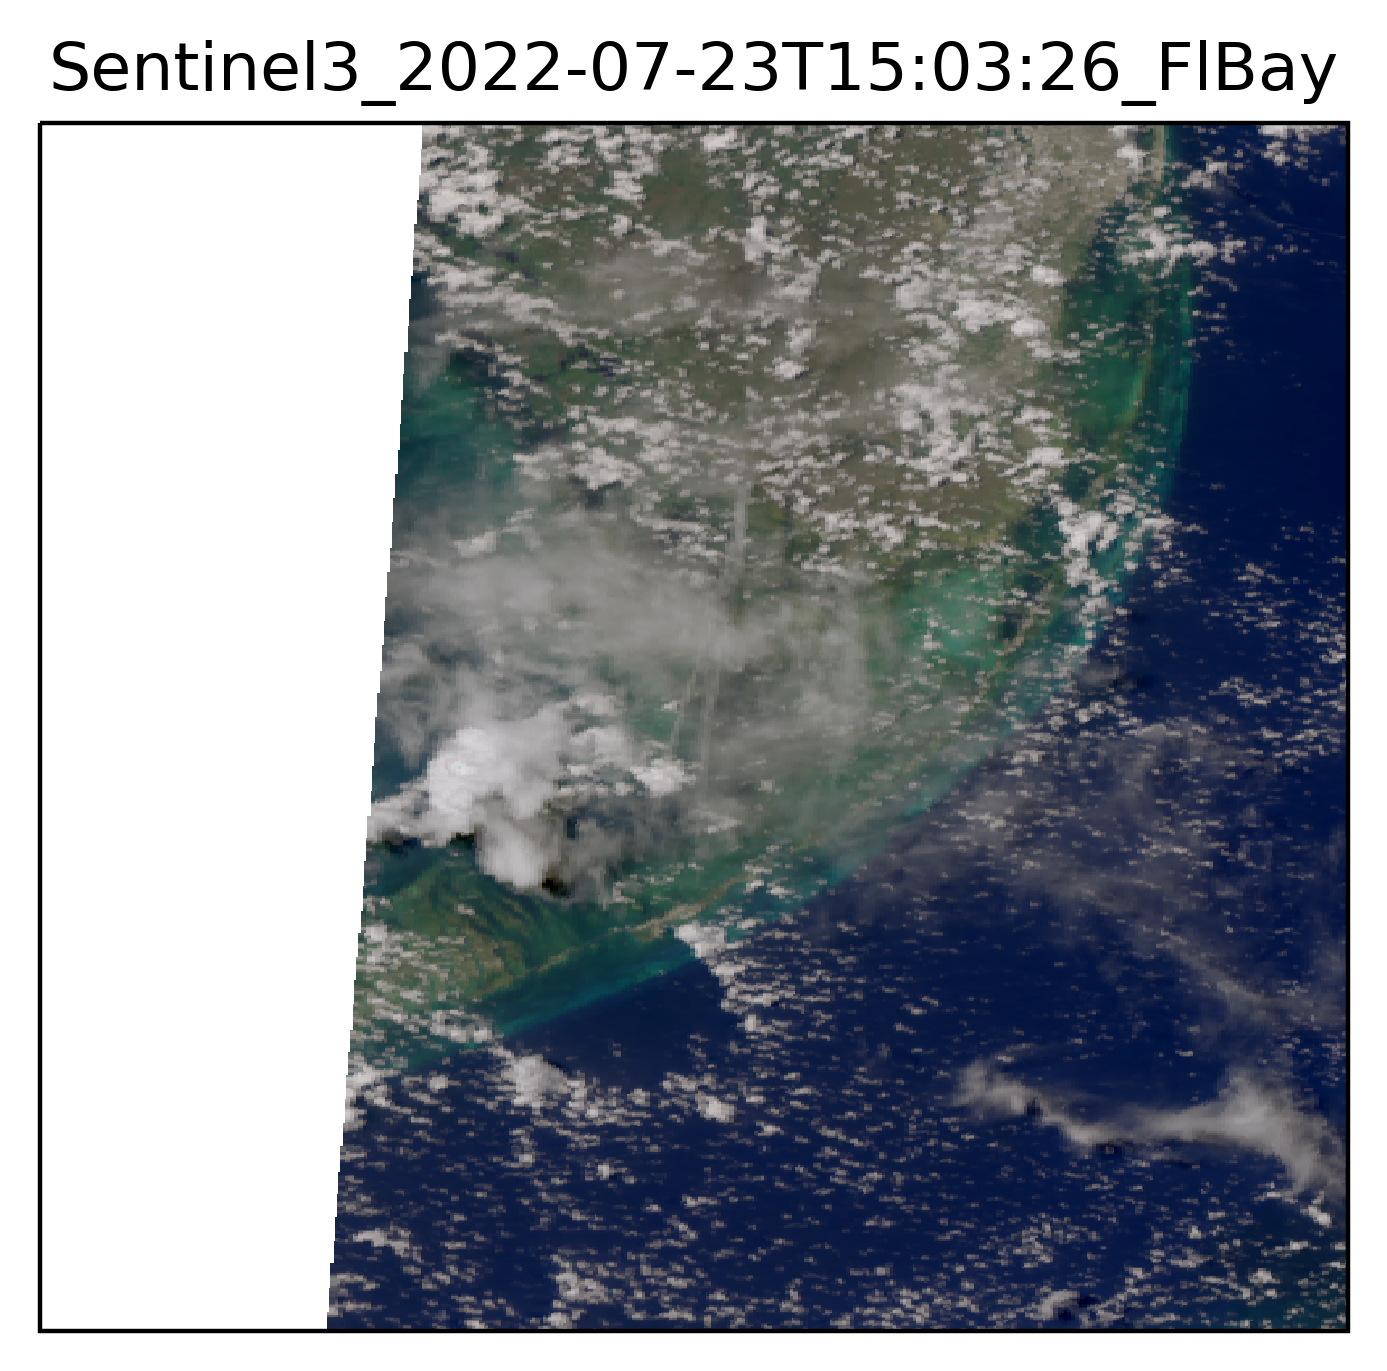

In [4]:
consumer_key = 'yawsJIqGoAetBf_MqpcByUwnrWMa'
consumer_secret = 'w6nWuFAtEgPhFESfK7Q4MzOs9t0a'

roi = [[-81.0955810546875,26.675685969067487],
       [-80.54489135742188,26.675685969067487],
       [-80.54489135742188,27.243641579169292],
       [-81.0955810546875,27.243641579169292],
       [-81.0955810546875,26.675685969067487]]

lon1 = -82
lat1 = 26
lon2 = -80
lat2 = 24

datastore = get_datastore(consumer_key, consumer_secret)
Sentinel_request(datastore, roi, lon1, lon2, lat1, lat2, opath='./products/', start_date=datetime.date(2022,7,23),
                 end_date=datetime.date(2022,7,24), suffix = "FlBay")

In [6]:
consumer_key = 'yawsJIqGoAetBf_MqpcByUwnrWMa'
consumer_secret = 'w6nWuFAtEgPhFESfK7Q4MzOs9t0a'

roi = [[-92.054443359375,29.14736383122664],
       [-89.2474365234375,29.14736383122664],
       [-89.2474365234375,30.372875188118016],
       [-92.054443359375,30.372875188118016],
       [-92.054443359375,29.14736383122664]]

lon1 = -92
lat1 = 29
lon2 = -89
lat2 = 30

datastore = get_datastore(consumer_key, consumer_secret)
Sentinel_request(datastore, roi, lon1, lon2, lat1, lat2, opath='./products/', start_date=datetime.date(2022,7,23),
                 end_date=datetime.date(2022,7,24), suffix = "Gomex")

This token '9d265725-2c36-3fdd-a63b-22d2199ebc4d' expires 2022-09-19 01:11:15.557990
OLCI Level 1B Full Resolution - Sentinel-3
Searching from 2022-07-23 00:00:00 to 2022-07-24 00:00:00
Found Datasets: 1 datasets for the given time range
Download of product S3B_OL_1_EFR____20220723T160517_20220723T160817_20220724T212100_0179_068_268_2520_MAR_O_NT_002.SEN3 finished.
All downloads are finished.
Unziping ./products/S3B_OL_1_EFR____20220723T160517_20220723T160817_20220724T212100_0179_068_268_2520_MAR_O_NT_002.SEN3.zip
Done! Files in ./products/S3_20220723_20220723
Starting visualization :D


KeyError: 'platform_name'